In [323]:
import sys
sys.path.append(r'C:\Users\USER\Documents\GitHub\frft')
sys.path.append(r'C:\Users\USER\Documents\GitHub\DLOCT\Analysis_cGAN')
import os
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft, fftfreq, fftshift, ifft
import sys
from tqdm import tqdm # for progress bars
from statistics import mean, stdev
from scipy.signal import find_peaks
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
import plotly.express as px
# Repositorio
sys.path.append(r'C:\Users\USER\Documents\GitHub\frft') 
import torch
import frft
import frft_gpu as frft_g
import time
from Deep_Utils import dbscale


def extract_dimensions(file_name):
    parts = file_name.split('_')
    dimensions = []
    for part in parts:
        if 'z=' in part or 'x=' in part or 'y=' in part:
            number = int(part.split('=')[-1])
            dimensions.append(number)
    return tuple(dimensions)

def read_tomogram(file_path, dimensions):
    depth, height, width = dimensions
    with open(file_path, 'rb') as file:
        tomogram = np.fromfile(file, dtype='single')
        tomogram = tomogram.reshape((depth, height, width),order='F')
    return tomogram

In [324]:
pathcomplex = r'C:\Users\USER\Documents\GitHub\[s.fovea]11bscan'
artifact_files = os.listdir(pathcomplex)
for imag_file, real_file in zip(artifact_files[::2], artifact_files[1::2]):
        real_file_path = os.path.join(pathcomplex, real_file)
        imag_file_path = os.path.join(pathcomplex, imag_file)
        dimensions = extract_dimensions(real_file[:-4])
        tomReal = read_tomogram(real_file_path, dimensions)
        tomImag = read_tomogram(imag_file_path, dimensions)
        tomcc = tomReal + 1j * tomImag
        del tomImag, tomReal
# fringescc = fftshift(ifft(fftshift(tom,axes=0),axis=0),axes=0)
fringescc = fftshift(ifft(tomcc,axis=0),axes=0)

pathcomplex = r'C:\Users\USER\Documents\GitHub\[s.fovea]11bscanNoartifacts'
artifact_files = os.listdir(pathcomplex)
for imag_file, real_file in zip(artifact_files[::2], artifact_files[1::2]):
        real_file_path = os.path.join(pathcomplex, real_file)
        imag_file_path = os.path.join(pathcomplex, imag_file)
        dimensions = extract_dimensions(real_file[:-4])
        tomReal = read_tomogram(real_file_path, dimensions)
        tomImag = read_tomogram(imag_file_path, dimensions)
        tom = tomReal + 1j * tomImag
        del tomImag, tomReal
# fringescc = fftshift(ifft(fftshift(tom,axes=0),axis=0),axes=0)
fringes = fftshift(ifft(tom,axis=0),axes=0)

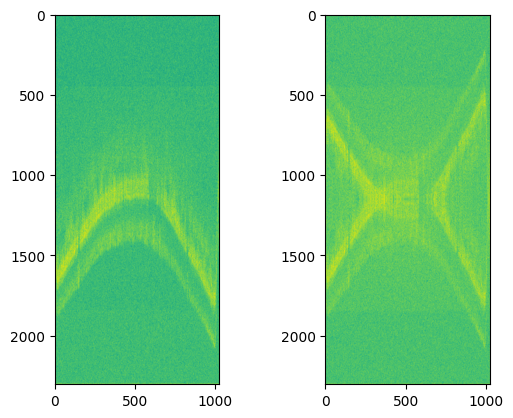

In [325]:
fig,axs = plt.subplots(nrows=1,ncols=2)
axs[0].imshow(dbscale(tom[:,:,0]))
axs[1].imshow(dbscale(tomcc[:,:,0]))

In [326]:
shape = np.shape(tomcc[:,:,0])
topad = int(abs(shape[0]-shape[1])/2)
nSnapshots = 11
alpha = np.linspace( 0., 2., nSnapshots )
bscan = 0
# obj_2d_shifted = fftshift(tomcc[:,:,bscan])
obj_2d_shifted = (np.pad(tomcc[:,:,bscan],pad_width=((0,0),(topad,topad))))
# obj_2d_shifted = fftshift(np.pad(tomcc[:,:,bscan],pad_width=((topad,topad),(0,0))))
obj_2d_shifted_gpu = torch.from_numpy( obj_2d_shifted ).cuda()
resultscc = []
gputime = []
for al in tqdm( alpha, total=alpha.size ):
  
    start = time.time()
    fobj_1d = frft_g.frft( obj_2d_shifted_gpu, al )
    t_gpu = time.time() - start
    gputime.append( t_gpu*1.e6 )
    resultscc.append( fftshift(torch.Tensor.numpy(torch.Tensor.cpu(fobj_1d))))

print( 'Mean GPU time = %f μs'%mean( gputime ) )

100%|██████████| 11/11 [00:02<00:00,  5.43it/s]


Mean GPU time = 23403.514515 μs


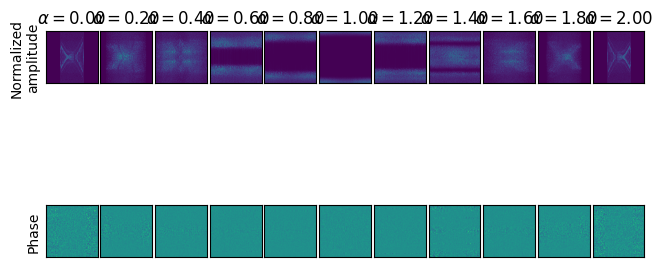

In [327]:
fig, ax = plt.subplots( 2, nSnapshots )
for n in range( nSnapshots ):
    ax[0,n].imshow( fftshift(np.absolute( resultscc[n] )/np.absolute( resultscc[n].max()) ) )
    ax[0,n].set_xticks( [] )
    ax[0,n].set_yticks( [] )
    ax[0,n].set_title( r'$\alpha = %.2f$'%alpha[n] )
    
    ax[1,n].imshow((np.angle( resultscc[n] )) )
    ax[1,n].set_xticks( [] )
    ax[1,n].set_yticks( [] )


ax[0,0].set_ylabel( 'Normalized\namplitude' )
ax[1,0].set_ylabel( 'Phase')

fig.tight_layout( pad=0.2, h_pad=0.2 )

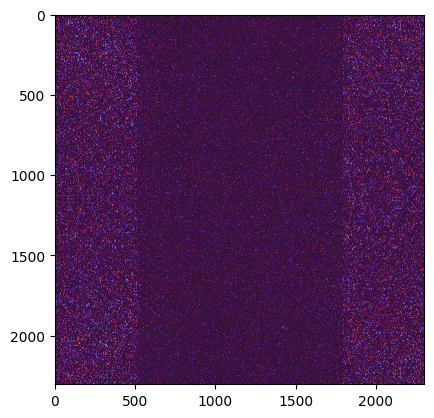

In [328]:
n=10
# unwrapped2d = np.unwrap(np.unwrap(np.angle(resultscc[n]),axis=0),axis=1)
# unwrapped = (np.unwrap(np.angle(resultscc[n])))
plt.imshow((np.angle(resultscc[n])),cmap='twilight')


In [329]:
topad = int(abs(shape[0]-shape[1])/2)
alpha = np.linspace( 0., 2., nSnapshots )
bscan = 0
# obj_2d_shifted = fftshift(tomcc[:,:,bscan])
obj_2d_shifted = (np.pad(tom[:,:,bscan],pad_width=((0,0),(topad,topad))))
# obj_2d_shifted = fftshift(np.pad(tomcc[:,:,bscan],pad_width=((topad,topad),(0,0))))
obj_2d_shifted_gpu = torch.from_numpy( obj_2d_shifted ).cuda()
results = []
gputime = []
for al in tqdm( alpha, total=alpha.size ):
  
    start = time.time()
    fobj_1d = frft_g.frft( obj_2d_shifted_gpu, al )
    t_gpu = time.time() - start
    gputime.append( t_gpu*1.e6 )
    results.append(fftshift (torch.Tensor.numpy(torch.Tensor.cpu(fobj_1d))))

print( 'Mean GPU time = %f μs'%mean( gputime ) )

100%|██████████| 11/11 [00:01<00:00,  6.40it/s]


Mean GPU time = 991.886312 μs


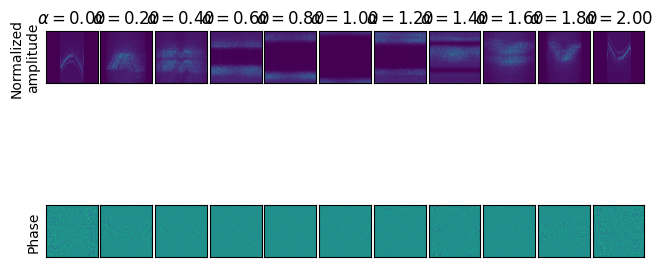

In [330]:
fig2, ax = plt.subplots( 2, nSnapshots )
for n in range( nSnapshots ):
    ax[0,n].imshow(fftshift(np.absolute( results[n] )/np.absolute( results[n].max() )) )
    ax[0,n].set_xticks( [] )
    ax[0,n].set_yticks( [] )
    ax[0,n].set_title( r'$\alpha = %.2f$'%alpha[n] )
    
    ax[1,n].imshow( ((np.angle( results[n] ))) )
    ax[1,n].set_xticks( [] )
    ax[1,n].set_yticks( [] )


ax[0,0].set_ylabel( 'Normalized\namplitude' )
ax[1,0].set_ylabel( 'Phase')

fig2.tight_layout( pad=0.2, h_pad=0.2 )

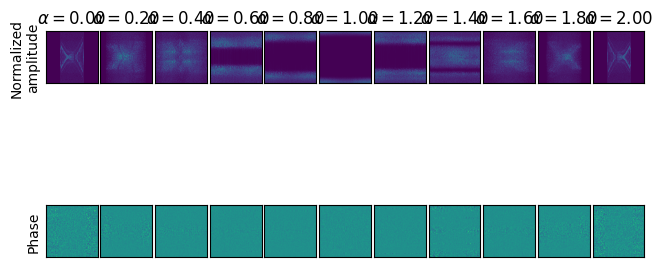

In [331]:
fig

[W 240716 20:05:06 frft_gpu:58] Recalculating chirp. 


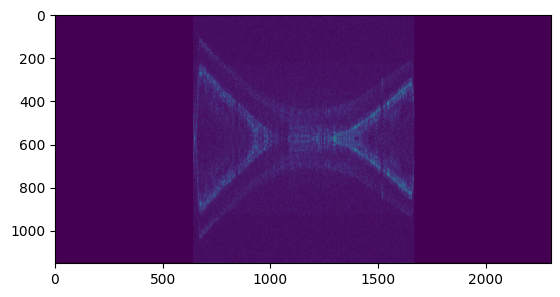

In [332]:
a = 5
obj_2d_shifted_gpufrft = torch.from_numpy( resultscc[a] ).cuda()
fobj_1dinv = frft_g.frft( obj_2d_shifted_gpufrft[0:int(len(obj_2d_shifted_gpufrft)/2)], alpha[a] )
inverse = (torch.Tensor.numpy(torch.Tensor.cpu(fobj_1dinv)))
plt.imshow(abs(inverse))

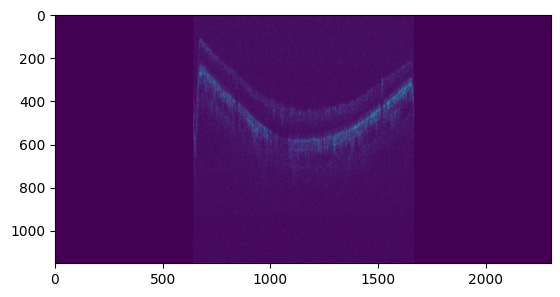

In [333]:
obj_2d_shifted_gpufrft = torch.from_numpy( results[a] ).cuda()
fobj_1dinv = frft_g.frft( obj_2d_shifted_gpufrft[0:int(len(obj_2d_shifted_gpufrft)/2)], alpha[a] )
inverse = (torch.Tensor.numpy(torch.Tensor.cpu(fobj_1dinv)))
plt.imshow(abs(inverse))

In [433]:
singleBscan = (fringescc[:,:,bscan])
bscanShape = np.shape(singleBscan)
nSnapshots = 11
alpha = np.linspace( 0., 2., nSnapshots )
bscanReconstructed = []
phaseReconstructed = []
unwrapedReconstructed = []
for i in tqdm(range(bscanShape[1])):
    obj_2d_shifted = (singleBscan[:,i])
    # obj_2d_shifted = fftshift(np.pad(tomcc[:,:,bscan],pad_width=((topad,topad),(0,0))))
    obj_2d_shifted_gpu = torch.from_numpy( obj_2d_shifted ).cuda()
    results = []
    phase = []
    unwraped=[]
    gputime = []
    for al in  alpha:
    
        start = time.time()
        fobj_1d = frft_g.frft( obj_2d_shifted_gpu, al )
        t_gpu = time.time() - start
        gputime.append( t_gpu*1.e6 )
        fobj_1dcpu = fftshift(torch.Tensor.numpy(torch.Tensor.cpu(fobj_1d)))
        fobj_1dphase = np.angle(fobj_1dcpu)
        results.append(fobj_1dcpu)
        phase.append(fobj_1dphase)
        unwraped.append(np.unwrap(fobj_1dphase))

    results = np.array(results)
    phase = np.array(phase)
    unwraped = np.array(unwraped)
    bscanReconstructed.append(results)
    phaseReconstructed.append(phase)
    unwrapedReconstructed.append(unwraped)

bscanReconstructed = np.array(bscanReconstructed)
phaseReconstructed = np.array(phaseReconstructed)
unwrapedReconstructed = np.array(unwrapedReconstructed)

100%|██████████| 1024/1024 [00:14<00:00, 69.36it/s]


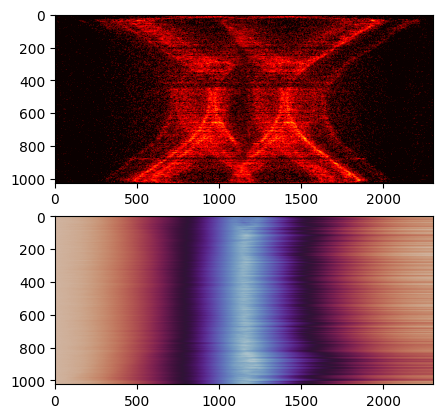

In [456]:
order = 7
fig,axs = plt.subplots(nrows=2,ncols=1)
axs[0].imshow(dbscale(bscanReconstructed[:,order,:]),cmap='hot',vmax=30,vmin=0)
axs[1].imshow((unwrapedReconstructed[:,order,:]),cmap='twilight')


11

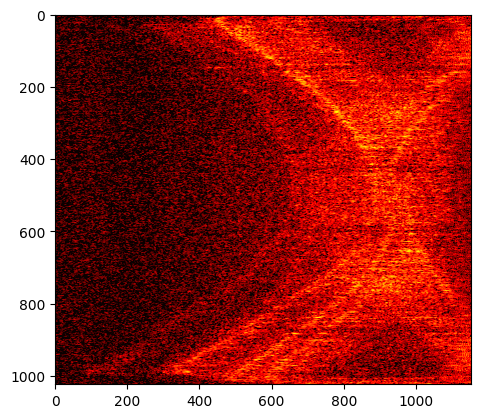

In [463]:
plt.imshow(dbscale(bscanReconstructed[:,order,0:int(bscanReconstructed.shape[2]/2)]-np.flip(bscanReconstructed[:,order,int(bscanReconstructed.shape[2]/2):])),
           cmap='hot',vmax=30,vmin=0)
bscanReconstructed.shape[1]